# Threaded computing in Julia

From YouTube lecture by Alan Edelman as part of MIT 18.S191 "Computational Thinking" Week 8 on Julia youtube channel.

https://www.youtube.com/watch?v=dczkYlOM2sg

Start by creating multithread kernel option for jupyter lab, or start with julia --numthreads 10

e.g.
installkernel("Julia (4 threads)", env=Dict("JULIA_NUM_THREADS" => "4")

In [3]:
Threads.nthreads()

4

In [4]:
using StaticArrays, Plots, StatsBase, FLoops

In [5]:
function birthday(n)
    success = 0
    for t = 1:n
        months = rand(1:12, 20)
        counts = [sum(months .== i) for i=1:12]
        success += sum(counts .== 2) == 4 && sum(counts .== 3) ==4
    end
    success/n
end

birthday (generic function with 1 method)

In [6]:
@time birthday(100_000)

  0.160207 seconds (2.84 M allocations: 201.013 MiB, 16.67% gc time)


0.00092

In [7]:
function birthday(n)
    success = 0
    for t = 1:n
        months = @SVector [rand(1:12) for i = 1:20]
        counts = @SVector [sum(months .== i) for i=1:12]
        success += sum(counts .== 2) == 4 && sum(counts .== 3) ==4
    end
    success/n
end

birthday (generic function with 1 method)

In [8]:
@time birthday(100_000)

  0.019295 seconds


0.00098

In [9]:
function birthday_distribution(t)
    v = zeros(t)
    for i = 1:t
        v[i] = birthday(50_000)
    end
    h = fit(Histogram, v, 0.0005:0.00001:0.0015)
end

birthday_distribution (generic function with 1 method)

In [10]:
@time h  = birthday_distribution(1_000)

  9.465601 seconds (3 allocations: 8.891 KiB)


Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}}
edges:
  0.0005:1.0e-5:0.0015
weights: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  3, 0, 4, 0, 2, 0, 3, 0, 0, 0]
closed: left
isdensity: false

In [12]:
sum(h.weights)

996

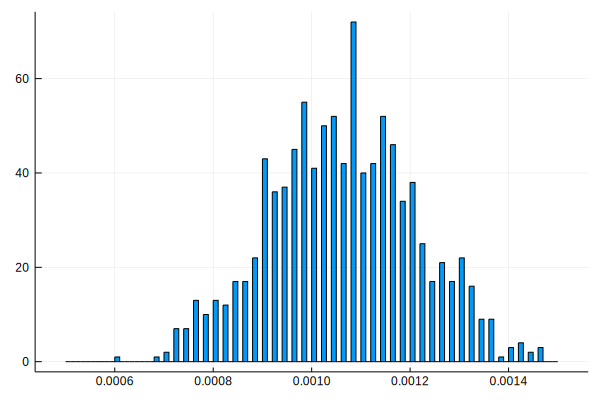

In [11]:
plot(h, legend=false)

In [21]:
function birthday_floop(t, ncores)
    v = 0
    @floop ThreadedEx(basesize = t ÷ ncores) for _ in 1:t
        months = @SVector [rand(1:12) for i = 1:20]
        counts = @SVector [sum(months .== i) for i=1:12]
        success = sum(counts .== 2) == 4 && sum(counts .== 3) ==4
        @reduce(v += success)
    end
    return v/t
end

birthday_floop (generic function with 1 method)

In [22]:
@time birthday_floop(1_000_000, 1)

  0.188914 seconds (9 allocations: 288 bytes)


0.001007

In [23]:
@time birthday_floop(1_000_000, 4)

  0.072936 seconds (10.56 k allocations: 682.504 KiB, 6.10% compilation time)


0.00107

In [18]:
function birthday_dist_floop(t, ncores)
    bins = 0.000005:0.0001:0.002
    empty_hist = birthday_distribution(0)
    @floop ThreadedEx(basesize= 1) for _ in 1:ncores
        @reduce(h =merge(empty_hist, birthday_distribution(t÷ncores)))
    end
    return(h)
end

birthday_dist_floop (generic function with 1 method)

In [19]:
@time h = birthday_dist_floop(1_000, 4)

  2.519215 seconds (11.60 k allocations: 870.899 KiB, 0.18% compilation time)


Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}}}
edges:
  0.0005:1.0e-5:0.0015
weights: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  3, 0, 0, 0, 3, 0, 2, 0, 2, 0]
closed: left
isdensity: false

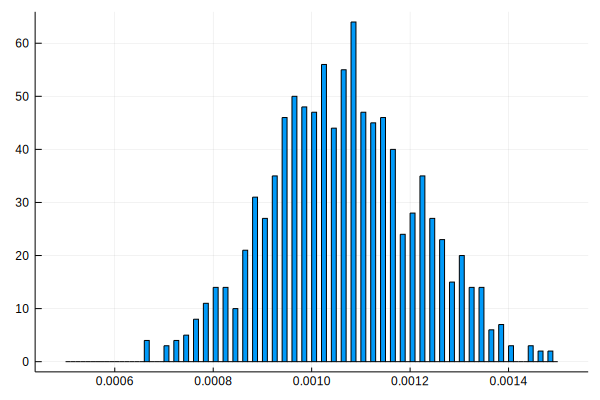

In [20]:
plot(h, legend=false)